---
title: "Image to image with Stable Diffusion"
date: "2024-03-24"
categories: [StableDiffusion, FastAI]
---

# Intro

This notebook performs an image to image transform using stable diffusion. This is one of the suggested homework assignments from lecture 10 of the [Fast AI course](https://course.fast.ai/)

Several parts of this code are borrowed from other notebooks found here https://github.com/fastai/diffusion-nbs. And parts of that  comes from the [Huggingface example notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

# Install packages and setup the packages

In [ ]:
!pip install -q --upgrade transformers diffusers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os
from fastdownload import FastDownload

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
#if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Loading the models

Instead of using a pipeline, for this excersize I'm loading all the separate components.

In [ ]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to("cuda")
text_encoder = text_encoder.to("cuda")
unet = unet.to("cuda");

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

# Download an image and convert to latent

Helper functions to go from latents to images and back

In [ ]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to("cuda")*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

Using a picture of a drawing my daughter has been working on. I've uploaded it to my google drive. First need to mount my google drive then open it from there.

In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


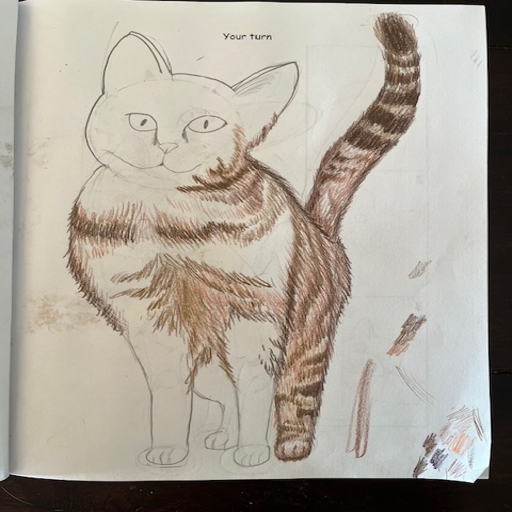

In [ ]:
img_path = '/content/drive/MyDrive/Colab Notebooks/IMG_7784.jpg'
init_image = Image.open(img_path)
init_image = init_image.resize((512, 512)).rotate(270)
init_image

In [ ]:
# Encode to the latent space
encoded = pil_to_latent(init_image)
encoded.shape

torch.Size([1, 4, 64, 64])

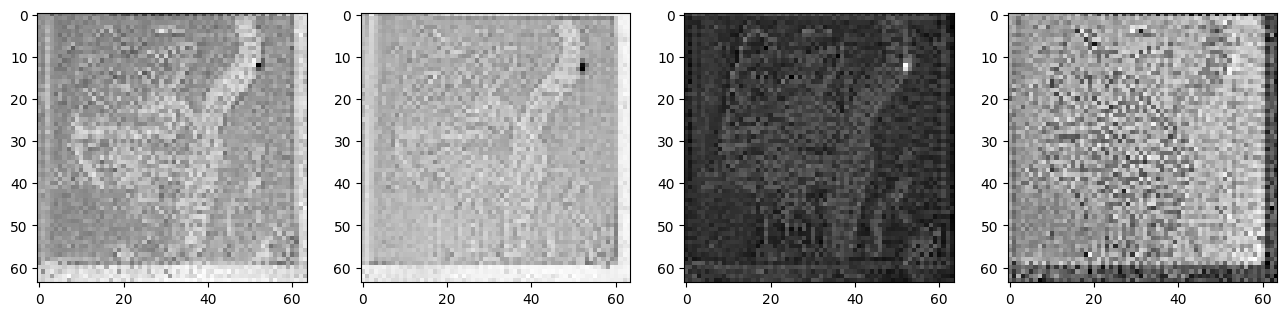

In [ ]:
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

# Setup the sheduler

In [ ]:
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)

In [ ]:
set_timesteps(scheduler, 50)
print(scheduler.timesteps)

tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490, 897.0612, 876.6735,
        856.2857, 835.8979, 815.5102, 795.1224, 774.7347, 754.3469, 733.9592,
        713.5714, 693.1837, 672.7959, 652.4081, 632.0204, 611.6326, 591.2449,
        570.8571, 550.4694, 530.0816, 509.6939, 489.3061, 468.9184, 448.5306,
        428.1429, 407.7551, 387.3673, 366.9796, 346.5918, 326.2041, 305.8163,
        285.4286, 265.0408, 244.6531, 224.2653, 203.8775, 183.4898, 163.1020,
        142.7143, 122.3265, 101.9388,  81.5510,  61.1633,  40.7755,  20.3878,
          0.0000])


tensor([14.6146, 12.9368, 11.4916, 10.2429,  9.1604,  8.2187,  7.3972,  6.6780,
         6.0465,  5.4903,  4.9989,  4.5633,  4.1761,  3.8308,  3.5221,  3.2451,
         2.9958,  2.7709,  2.5673,  2.3825,  2.2143,  2.0606,  1.9199,  1.7907,
         1.6716,  1.5617,  1.4598,  1.3651,  1.2768,  1.1944,  1.1171,  1.0444,
         0.9759,  0.9112,  0.8497,  0.7913,  0.7355,  0.6820,  0.6306,  0.5809,
         0.5328,  0.4858,  0.4397,  0.3940,  0.3483,  0.3019,  0.2535,  0.2012,
         0.1393,  0.0292,  0.0000])


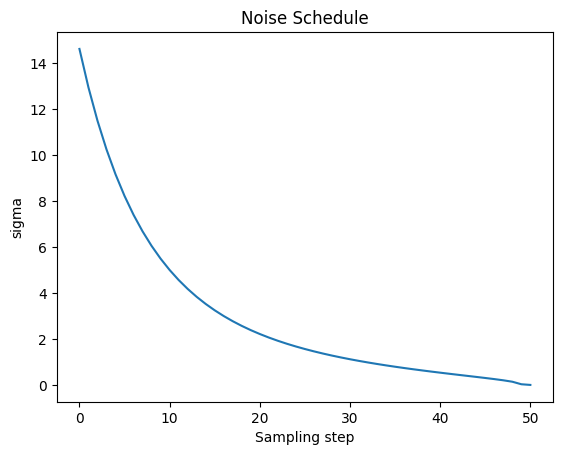

In [ ]:
# Look at the equivalent noise levels:
print(scheduler.sigmas)
# Plotting this noise schedule:
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

## View the latents vith various ammounts of noise
We will begin the img to img transformation with the starting image with various amounts of noise added to it. The loop will remove the noise as it converges on an image from the prompt we provide.

Looking at the latents below, I don't see much image structure until the 3rd image which is would be step 20 out of 50, so that may be a good starting point.

In [ ]:
noise = torch.randn_like(encoded)

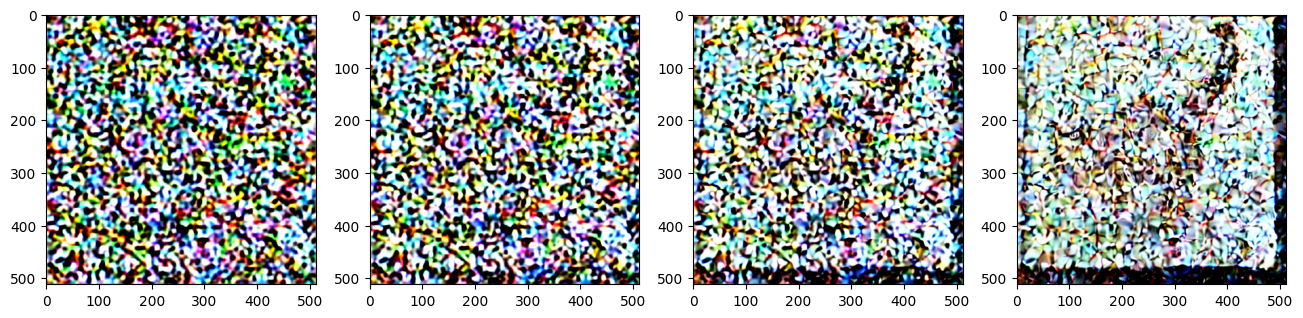

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    sampling_step = i * 10
    encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[sampling_step]]))
    img = latents_to_pil(encoded_and_noised.float())[0]
    axs[i].imshow(img)

# Create the text embeddings from the prompt

In [ ]:
steps = 50
start_step = 20
guidance_scale = 8
prompt = ["a picture of an ocelot walking through a rainforest"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
generator = torch.manual_seed(50)   # Seed generator to create the inital latent noise
batch_size = 1

In [ ]:
set_timesteps(scheduler, steps)

In [ ]:
# Prep latents (noising appropriately for start_step)
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
latents = latents.to("cuda").float()

In [ ]:
# Prep text (same as before)
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Run the loop

  0%|          | 0/50 [00:00<?, ?it/s]

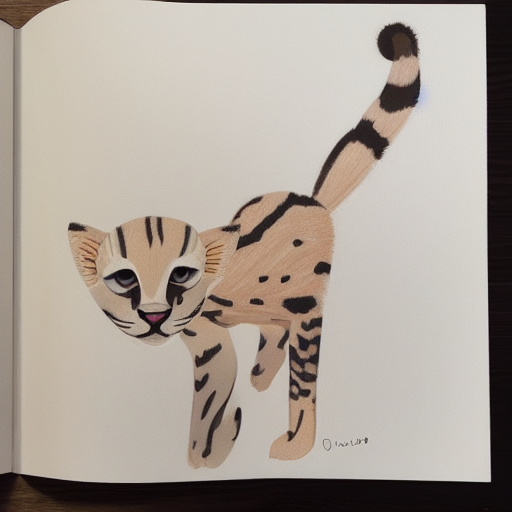

In [ ]:
# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    if i >= start_step: # << This is the only modification to the loop we do

        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

latents_to_pil(latents)[0]

# Final thoughts.

I think the output is pretty neat outside of the ocelot having only 3 legs. I did run the loop with a few different starting seed values and picked the one I liked best.

From here it would be interesting to play with different settings such as:
* starting step
* total ste
* guidance scale

